<a href="https://colab.research.google.com/github/yrrSelena/RUL/blob/master/RUL_CMAPSS_LSTM_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 载入库

In [1]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# 读取数据

## 设置常量参数

In [0]:
train_file = 'train_FD001.txt'
test_file = 'test_FD001.txt'
test_rul_file = 'RUL_FD001.txt'
n_ftrs = 26
n_units = 100
col_name = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
             's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
             's15', 's16', 's17', 's18', 's19', 's20', 's21']

## 载入数据

In [0]:
# read training data - It is the aircraft engine run-to-failure data.
raw_train_df = pd.read_csv(train_file,names = col_name, header=None,delim_whitespace=True)
raw_test_df = pd.read_csv(test_file,names = col_name, header=None,delim_whitespace=True)
raw_rul_df = pd.read_csv(test_rul_file, names=['RUL'],header=None,delim_whitespace=True) 

In [0]:
train_df = raw_train_df
test_df = raw_test_df
rul_df = raw_rul_df

In [0]:
ftr_col_name = train_df.columns.difference(['id','cycle'])

In [7]:
ftr_col_name

Index(['s1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18',
       's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9',
       'setting1', 'setting2', 'setting3'],
      dtype='object')

# 数据预处理

## 训练数据

### 计算RUL

In [0]:
train_df = raw_train_df
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index() #添加一列作为索引
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

In [98]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


### 数据平滑处理

In [0]:
def smoothEWM(data,n_units,ftr_col_name,ewm_win_size):
    data_group = data.groupby(data['id'])
    ewm_ftr = pd.DataFrame()
    for unit_no in range(1,n_units+1):
        tmp_unit = data_group.get_group(unit_no)
        tmp_unit1 = tmp_unit.loc[:,ftr_col_name].ewm(span=ewm_win_size).mean()
        ewm_ftr = pd.concat([ewm_ftr,tmp_unit1])#ewm_ftr.append(tmp_unit1)
    ewm_ftr['id'] = data['id']
    ewm_ftr['cycle'] = data['cycle']
    return ewm_ftr

In [0]:
ewm_win_size = 10
ewm_train_ftr = pd.DataFrame()
ewm_train_ftr = smoothEWM(train_df, n_units, ftr_col_name,ewm_win_size)

In [0]:
ewm_train_ftr = ewm_train_ftr[col_name]
ewm_train_ftr['RUL'] = train_df['RUL']
train_df = ewm_train_ftr

### MinMax归一化处理

In [0]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])

# 对数据进行min-max归一化处理[0,1]
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [102]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.527273,0.166667,0.0,0.0,0.152747,0.495953,0.307035,0.0,1.0,0.766807,0.361307,0.091366,0.0,0.425668,0.640978,0.231062,0.200888,0.446382,0.0,0.287032,0.0,0.0,0.767506,0.768934,191,0.00000
1,1,2,0.657273,0.212500,0.0,0.0,0.227676,0.530622,0.339481,0.0,1.0,0.689345,0.332918,0.085096,0.0,0.434339,0.741327,0.301665,0.177575,0.480236,0.0,0.287032,0.0,0.0,0.730972,0.773978,190,0.00277
2,1,3,0.473452,0.428571,0.0,0.0,0.285511,0.496246,0.360049,0.0,1.0,0.711203,0.365079,0.102209,0.0,0.367477,0.790895,0.283604,0.174066,0.463207,0.0,0.171647,0.0,0.0,0.696703,0.712003,189,0.00554
3,1,4,0.533114,0.452104,0.0,0.0,0.313856,0.428461,0.352301,0.0,1.0,0.736368,0.406349,0.104466,0.0,0.298350,0.857846,0.317044,0.173521,0.373086,0.0,0.209661,0.0,0.0,0.654375,0.701137,188,0.00831
4,1,5,0.500120,0.418008,0.0,0.0,0.332788,0.389367,0.376776,0.0,1.0,0.721245,0.393418,0.114538,0.0,0.291904,0.840364,0.307101,0.173151,0.408349,0.0,0.273072,0.0,0.0,0.636001,0.712244,187,0.01108


### 特征筛选

In [103]:
t = train_df.max()==0
rebundant_ftr_name = t[t==True].index.tolist() #7个常量特征
selected_ftr_name = train_df.columns.difference(rebundant_ftr_name)
selected_ftr_name

Index(['RUL', 'cycle', 'cycle_norm', 'id', 's11', 's12', 's13', 's14', 's15',
       's17', 's2', 's20', 's21', 's3', 's4', 's6', 's7', 's8', 's9',
       'setting1', 'setting2'],
      dtype='object')

In [95]:
rebundant_ftr_name

['setting3', 's1', 's5', 's10', 's16', 's18', 's19']

In [104]:
#train_df =train_df.loc[:,selected_ftr_name]
train_df.drop(rebundant_ftr_name, axis=1, inplace=True)
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL,cycle_norm
0,1,1,0.527273,0.166667,0.152747,0.495953,0.307035,1.0,0.766807,0.361307,0.091366,0.425668,0.640978,0.231062,0.200888,0.446382,0.287032,0.767506,0.768934,191,0.00000
1,1,2,0.657273,0.212500,0.227676,0.530622,0.339481,1.0,0.689345,0.332918,0.085096,0.434339,0.741327,0.301665,0.177575,0.480236,0.287032,0.730972,0.773978,190,0.00277
2,1,3,0.473452,0.428571,0.285511,0.496246,0.360049,1.0,0.711203,0.365079,0.102209,0.367477,0.790895,0.283604,0.174066,0.463207,0.171647,0.696703,0.712003,189,0.00554
3,1,4,0.533114,0.452104,0.313856,0.428461,0.352301,1.0,0.736368,0.406349,0.104466,0.298350,0.857846,0.317044,0.173521,0.373086,0.209661,0.654375,0.701137,188,0.00831
4,1,5,0.500120,0.418008,0.332788,0.389367,0.376776,1.0,0.721245,0.393418,0.114538,0.291904,0.840364,0.307101,0.173151,0.408349,0.273072,0.636001,0.712244,187,0.01108


## 测试数据

### 数据平滑处理

In [0]:
test_df = raw_test_df

In [0]:
ewm_test_ftr = pd.DataFrame()
ewm_test_ftr = smoothEWM(test_df, n_units, ftr_col_name,ewm_win_size)
ewm_test_ftr = ewm_test_ftr[col_name]

In [107]:
test_df = ewm_test_ftr
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.002300,0.000300,100.0,518.67,643.020000,1585.290000,1398.210000,14.62,21.61,553.900000,2388.040000,9050.170000,1.3,47.200000,521.720000,2388.030000,8125.550000,8.405200,0.03,392.000000,2388.0,100.0,38.860000,23.373500
1,1,2,-0.000450,-0.000030,100.0,518.67,642.299500,1587.028000,1396.675500,14.62,21.61,554.422500,2388.023500,9052.507500,1.3,47.365000,521.962000,2388.046500,8133.288500,8.391505,0.03,392.550000,2388.0,100.0,38.948000,23.383455
2,1,3,-0.000149,0.000022,100.0,518.67,642.364020,1586.992625,1398.550598,14.62,21.61,554.296877,2388.034153,9054.297375,1.3,47.419269,521.965216,2388.039867,8132.006744,8.412648,0.03,392.730897,2388.0,100.0,39.001063,23.396779
3,1,4,0.001284,0.000015,100.0,518.67,642.389052,1586.046223,1401.143215,14.62,21.61,554.222131,2388.032785,9051.329847,1.3,47.373386,521.772413,2388.043205,8132.301032,8.405746,0.03,392.160644,2388.0,100.0,39.000713,23.389176
4,1,5,0.001317,0.000011,100.0,518.67,642.423773,1586.374570,1401.366209,14.62,21.61,554.204295,2388.026244,9049.383537,1.3,47.355190,521.880808,2388.039415,8131.508415,8.404987,0.03,391.540382,2388.0,100.0,38.997637,23.396015


### MinMax归一化处理

In [0]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [0]:
raw_rul_df = pd.read_csv(test_rul_file, names=['RUL'],header=None,delim_whitespace=True) 
rul_df = raw_rul_df

In [111]:
rul_df.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### 计算测试数据的RUL

In [0]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index() 
rul.columns = ['id', 'max']
rul_df.columns = ['more']
rul_df['id'] = rul_df.index + 1 # 获得每个发动机的编号
rul_df['max'] = rul['max'] + rul_df['more'] # 测试数据的生命周期=发动机的运行时间+剩余寿命
rul_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(rul_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


In [113]:
test_df.drop(rebundant_ftr_name, axis=1, inplace=True)
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,cycle_norm,RUL
0,1,1,0.800000,0.750000,0.648143,0.364829,0.251527,1.0,0.660600,0.309691,0.112770,0.212834,0.658634,0.256736,0.123188,0.374820,0.287032,0.546084,0.678223,0.00000,142
1,1,2,0.550000,0.475000,0.350699,0.416505,0.215889,1.0,0.781237,0.267109,0.125341,0.342899,0.729850,0.299097,0.169193,0.306287,0.365966,0.643510,0.698070,0.00277,141
2,1,3,0.577409,0.518549,0.377335,0.415454,0.259438,1.0,0.752233,0.294601,0.134967,0.385678,0.730797,0.282068,0.161573,0.412092,0.391927,0.702257,0.724633,0.00554,140
3,1,4,0.707649,0.512438,0.387669,0.387314,0.319652,1.0,0.734975,0.291070,0.119008,0.349510,0.674059,0.290639,0.163322,0.377555,0.310087,0.701869,0.709474,0.00831,139
4,1,5,0.710672,0.508867,0.402002,0.397077,0.324831,1.0,0.730857,0.274190,0.108541,0.335166,0.705957,0.280906,0.158610,0.373753,0.221069,0.698464,0.723110,0.01108,138


In [0]:
train_df = train_df[test_df.columns]

In [115]:
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,cycle_norm,RUL
0,1,1,0.527273,0.166667,0.152747,0.495953,0.307035,1.0,0.766807,0.361307,0.091366,0.425668,0.640978,0.231062,0.200888,0.446382,0.287032,0.767506,0.768934,0.00000,191
1,1,2,0.657273,0.212500,0.227676,0.530622,0.339481,1.0,0.689345,0.332918,0.085096,0.434339,0.741327,0.301665,0.177575,0.480236,0.287032,0.730972,0.773978,0.00277,190
2,1,3,0.473452,0.428571,0.285511,0.496246,0.360049,1.0,0.711203,0.365079,0.102209,0.367477,0.790895,0.283604,0.174066,0.463207,0.171647,0.696703,0.712003,0.00554,189
3,1,4,0.533114,0.452104,0.313856,0.428461,0.352301,1.0,0.736368,0.406349,0.104466,0.298350,0.857846,0.317044,0.173521,0.373086,0.209661,0.654375,0.701137,0.00831,188
4,1,5,0.500120,0.418008,0.332788,0.389367,0.376776,1.0,0.721245,0.393418,0.114538,0.291904,0.840364,0.307101,0.173151,0.408349,0.273072,0.636001,0.712244,0.01108,187


# 生成样本特征

In [0]:
sequence_length = 30 #设置时间窗口大小
sequence_cols = list(selected_ftr_name.difference(['RUL','cycle','id'])) #设置特征(18)

In [137]:
len(sequence_cols)

18

In [0]:
# pick a large window size of 50 cycles

# function to reshape features into (samples, time steps, features) 
# 生成特征样本
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones 
    只有比时间窗口大的序列会被提取特征，若测试样本的时间序列过小，则被忽视。
    另一种方法是对序列进行填充
    """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values # 获得对应列的值
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 141 to 191
    
    # zip将数据打包为元组的列表
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :] #yield 相当于返回
        

In [139]:
# TODO for debug 
# 样例测试
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 18 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

162


In [140]:
# 对每个发动机生成训练样本
# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(17631, 30, 18)


In [141]:
train_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,cycle_norm,RUL
0,1,1,0.527273,0.166667,0.152747,0.495953,0.307035,1.0,0.766807,0.361307,0.091366,0.425668,0.640978,0.231062,0.200888,0.446382,0.287032,0.767506,0.768934,0.00000,191
1,1,2,0.657273,0.212500,0.227676,0.530622,0.339481,1.0,0.689345,0.332918,0.085096,0.434339,0.741327,0.301665,0.177575,0.480236,0.287032,0.730972,0.773978,0.00277,190
2,1,3,0.473452,0.428571,0.285511,0.496246,0.360049,1.0,0.711203,0.365079,0.102209,0.367477,0.790895,0.283604,0.174066,0.463207,0.171647,0.696703,0.712003,0.00554,189
3,1,4,0.533114,0.452104,0.313856,0.428461,0.352301,1.0,0.736368,0.406349,0.104466,0.298350,0.857846,0.317044,0.173521,0.373086,0.209661,0.654375,0.701137,0.00831,188
4,1,5,0.500120,0.418008,0.332788,0.389367,0.376776,1.0,0.721245,0.393418,0.114538,0.291904,0.840364,0.307101,0.173151,0.408349,0.273072,0.636001,0.712244,0.01108,187


# 生成样本标签

In [0]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [142]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(17631, 1)

# 构建深度网络

In [0]:
# define path to save model
model_path = 'LSTM1.h5'

In [143]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# 采用Dropout防止过拟合
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
# 由于此问题是回归问题，因此在最后采用单一神经元以及一个线性激活函数

nb_features = seq_array.shape[2] # 特征数目：25
nb_out = label_array.shape[1] # 输出大小：1

# 定义一个sequential模型（多个网络层线性堆叠而成）
model = Sequential()
# 向模型中加入layer
model.add(LSTM(
         input_shape=(sequence_length, nb_features),#第一层需要接收一个样本数据shape的参数
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2)) #增加一个Dropout
model.add(Dense(units=nb_out)) #密集模块
model.add(Activation("linear")) # 线性激活函数
# 编译模型，对model进行配置
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
# 采用MSE进行模型训练，采用rmsprop作为优化器，采用mae和自己定义的r2_keras进行性能评估

print(model.summary())

# fit the network
# 模型训练
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 100)           47600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________
None
T

In [144]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_r2_keras', 'loss', 'mean_absolute_error', 'r2_keras'])


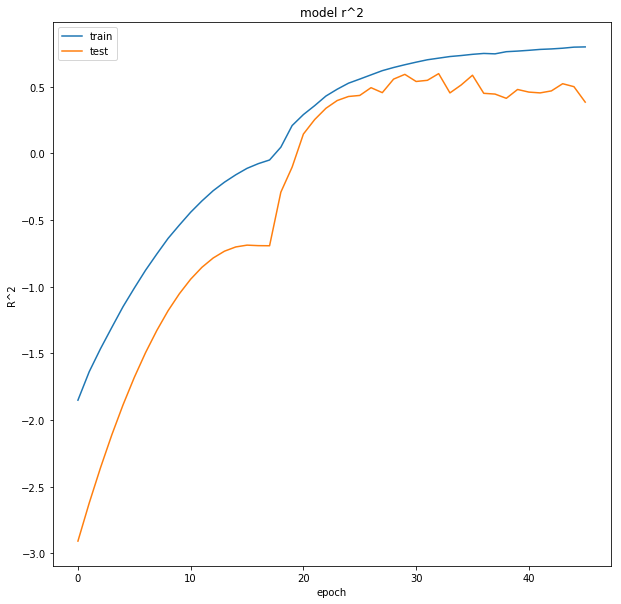

In [145]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

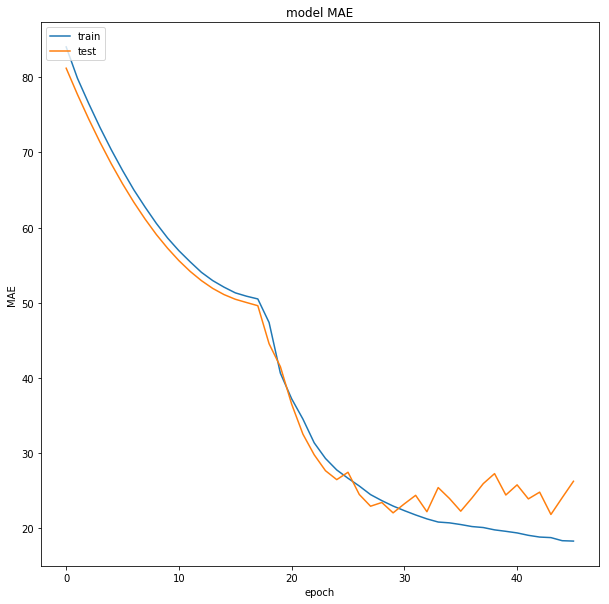

In [146]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

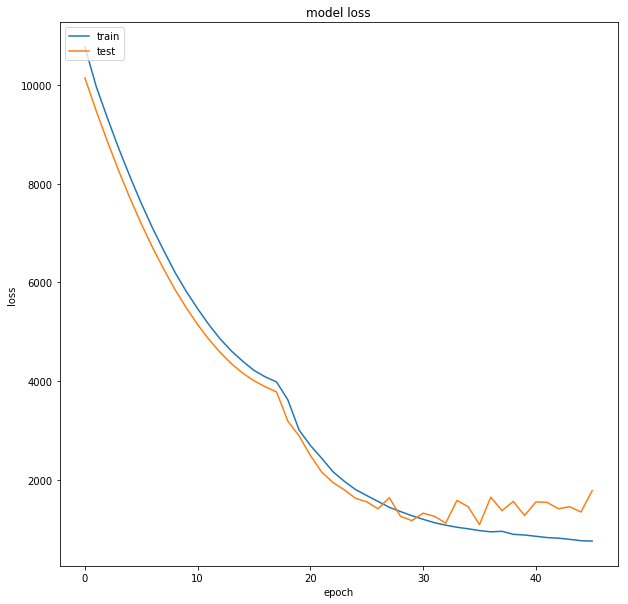

In [147]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [148]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

17631/17631 [==============================] - 3s 187us/step

MAE: 18.195992439036996

R^2: 0.7272755407880015
17631/17631 [==============================] - 4s 228us/step


In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import math

In [0]:
def RHS_score(y_true, y_pred):
  s = 0
  delta = y_pred-y_true
  for i in range(len(delta)):
      if delta[i]<0:
          s+=math.e**(-delta[i]/13)-1
      else:
          s+=math.e**(delta[i]/10)-1
  #s = s/len(delta)
  return s

In [0]:
delta = y_pred-y_true

In [155]:
mse_valid = np.sum((y_pred - y_true)**2)/len(y_true)
rmse_valid = mse_valid**0.5
mae_valid = np.sum(np.absolute(y_pred - y_true))/len(y_true)
r2_valid = 1 - mse_valid/np.var(y_true)
rhs_valid = RHS_score(y_true,y_pred)
print('mse:',mse_valid)
print('rmse:',rmse_valid)
print('mae:',mae_valid)
print('r2:',r2_valid)
print('rhs:',rhs_valid)

mse: 832.2506380806534
rmse: 28.84875453257304
mae: 18.195993562475184
r2: 0.7812967828962225
rhs: [1.3818358e+08]


In [0]:
mse_valid = np.sum((y_pred - y_true)**2)/len(y_true)
rmse_valid = mse_valid**0.5
mae_valid = np.sum(np.absolute(y_pred - y_true))/len(y_true)
r2_valid = 1 - mse_valid/np.var(y_true)
rhs_valid = RHS_score(y_true,y_pred)
print('mse:',mse_valid)
print('rmse:',rmse_valid)
print('mae:',mae_valid)
print('r2:',r2_valid)
print('rhs:',rhs_valid)

mse: 377.39428059625106
rmse: 19.426638427588315
mae: 12.075915848314247
r2: 0.8844198311195588
rhs: 77.69869969931547


In [0]:
model.save(model_path)

In [0]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 8s 480us/step

MAE: 12.075915369006115

R^2: 0.8509904890156214


In [0]:
y_pred.shape

(15631, 1)

In [0]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)




MAE: 17.57666488647461

R^2: 0.5966247606277466


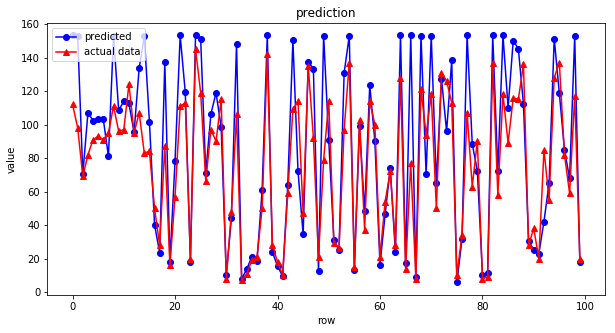

In [157]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras}) # 加载模型

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, 'b-o')
    plt.plot(y_true_test, 'r-^')
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

In [158]:
mse_test = np.sum((y_pred_test - y_true_test)**2)/len(y_true_test)
rmse_test = mse_test**0.5
mae_test = np.sum(np.absolute(y_pred_test - y_true_test))/len(y_true_test)
r2_test = 1 - mse_test/np.var(y_true_test)
rhs_test = RHS_score(y_true_test,y_pred_test)
print('mse:',mse_test)
print('rmse:',rmse_test)
print('mae:',mae_test)
print('r2:',r2_test)
print('rhs_test:',rhs_test)


mse: 600.9874609375
rmse: 24.515045603414652
mae: 17.576666259765624
r2: 0.6519786477446918
rhs_test: [6131.9897]


In [153]:
y_pred_test.shape

(100, 1)